In [6]:
#@title load modules and select input PLAID file
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import glob
import os
import math
import re
import datetime

#from google.colab import files
#idot_log = files.upload()

In [76]:
#@title User input 

user_name             = 'Jonne' #@param ["Jonne", "Christa", "Amelie","Malin","Martin","Polina"]
protocol_name         = "myexp" #@param {type:"string"} # Name of the protocol

sourceplate_type      = "S.100 Plate" #@param ["S.100 Plate","S.60 Plate","S.200 Plate"] 
target_plate_type     = 'MWP 384' #@param ["MWP 96","MWP 384"]

working_volume_ul     = 40.0 #@param {type:"number"}
V2_ul                 = working_volume_ul

x = datetime.datetime.now()

software      = "1.7.2021.1019" # I-DOT Assay Studio software version
user_name     = user_name # User name/ID
date          = (x.strftime("%x")) 
time          = (x.strftime("%X")) 

sourceplate_type = "S.100 Plate" # Other options are "S.60 Plate" and "S.200 Plate"
sourceplate_name = "source_name" # Name of source plate
max_volume       = 8.0E-5 # Source plate max volume (80000nL = 80uL= 8.0E-5 L)
target_plate_type= target_plate_type  # Other options are "MWP 96" and "MWP 1536" 
targetplate_name = "target_name"
waste            = "Waste Tube" # Position of the waste well on the target carrier

dispense_to_waste          = True # Enable/disable priming before dispensing (=True/False) 
dispense_to_waste_cycles   = 3 # Number of priming cycles for each source well (=1/2/3)
dispense_to_waste_volume   = 1e-7 # Dispensing volume for each priming cycle (=5e-8/.../1e-6) 
use_deionisation           = True
optimization_level         = "ReorderAndParallel" # Used protocol optimization process to reduce total dispensing time. Possible values are NoOptimization / Reorder / ReorderAndParalell
waste_error_handling_level = "Ask" # Checkpoint for the dispensing run if no droplets are detected during priming. Possible values are Ask / Abort / Continue 
save_liquids               = "Ask" # Checkpoint for Liquid Library handling. Possible options are Ask / Never


In [9]:
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving PrintLog_2022-12-20_17-01-52.txt to PrintLog_2022-12-20_17-01-52 (9).txt
User uploaded file "PrintLog_2022-12-20_17-01-52.txt" with length 43698 bytes


In [59]:
log = pd.read_csv('PrintLog_2022-12-20_17-01-52.txt', sep=',', header=None)
delimiter = '\t'
df2 = log[0].str.split(delimiter, expand=True)
df2 = df2.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # remove all whitespaces

df2


,0,1,2,3,4,5,6,7,8
0,ProtocolName: 3_idotprotocol_BFMOALIVE,None,None,None,None,None,None,None,None
1,DateTime: 2022-12-20 17:01:52,None,None,None,None,None,None,None,None
2,SoftwareProductVersion: 1.7.9,None,None,None,None,None,None,None,None
3,SoftwareBuildVersion: 1.7.2021.1105,None,None,None,None,None,None,None,None
4,Source Plate ID: DMSOsource1 (PURE_S_100) - Ba...,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
416,[noca][10],B1,K19,0.054,0.09325,2,0,40 nL,142
417,[noca][10],B1,M20,0.063,0.09775,2,0,40 nL,142
418,[noca][10],B1,B21,0.0135,0.10225,2,0,40 nL,142
419,[noca][10],B1,B23,0.0135,0.11125,2,0,40 nL,142


In [60]:
#extract plate names
plates = df2[df2[0].str.startswith('Target')][0].str.extract(r"\:(.*?)\(")
plates = plates[0].str.strip().tolist()
plates

['plate_1', 'plate_1', 'plate_1']

In [61]:
# find where the protcols split

end = [int(df2.tail(1).index.item())]
split =  df2.index[df2[0]=="Liquid"].tolist()
startprot = [i for i in split]

endprot = startprot[1:] 
endprot = [i -3 for i in endprot]
endprot = endprot + end 

In [62]:
masterdf = []

for i, stindex in enumerate(startprot): 
    start = startprot[i] + 1
    end = endprot[i] 
    
    df = df2[start:end]
    df["Target Plate"] = plates[i]
    masterdf.append(df)

df = pd.concat(masterdf)

In [63]:
df.columns = ["Liquid Name","Source","Target Well","TargetFwd","TargetSide","Drop","Miss","TargetVolume","DosingEnergy","Target Plate"]
df["Miss"] = pd.to_numeric(df["Miss"])
df["Drop"] = pd.to_numeric(df["Drop"])

df[["TargetVolume", "TargetUnit"]] = df["TargetVolume"].str.split(" ", expand=True)
df["TargetVolume"] = pd.to_numeric(df["TargetVolume"])

df = df.loc[(df["Target Well"] != "Waste")]
missed = df.loc[df['Miss'] != 0]

missed

,Liquid Name,Source,Target Well,TargetFwd,TargetSide,Drop,Miss,TargetVolume,DosingEnergy,Target Plate,TargetUnit
313,[flup][10],D1,N2,0.0675,0.01675,1,1,40.0,142,plate_1,nL
315,[flup][10],D1,I4,0.045,0.02575,0,2,40.0,142,plate_1,nL
317,[flup][10],D1,B7,0.0135,0.03925,1,1,40.0,142,plate_1,nL
320,[flup][10],D1,J10,0.0495,0.05275,1,1,40.0,142,plate_1,nL
330,[flup][10],D1,H20,0.0405,0.09775,1,1,40.0,142,plate_1,nL
331,[flup][10],D1,E21,0.027,0.10225,1,1,40.0,142,plate_1,nL
332,[flup][10],D1,I22,0.045,0.10675,1,1,40.0,142,plate_1,nL


In [65]:
#@title Create overview of missed wells

missed["ratiomissed"]   =              missed.Miss / (missed.Drop + missed.Miss ) 
missed["Volume [uL]"]   =             (missed.ratiomissed * df.TargetVolume) / 1000

#missed['stock_conc_mM']  =   missed["Liquid"].str.extract(r"\[(.\d?)\]" , expand=False)
#missed['cmpdstock']      =   missed["Liquid"].str.extract(r"\[(.*?)\]" , expand=False)


target = missed[["Target Plate","Target Well","Volume [uL]", "Liquid Name"]]
targetplates = df['Target Plate'].unique().tolist()

print("An overview of missed wells")
target

An overview of missed wells


,Target Plate,Target Well,Volume [uL],Liquid Name
313,plate_1,N2,0.02,[flup][10]
315,plate_1,I4,0.04,[flup][10]
317,plate_1,B7,0.02,[flup][10]
320,plate_1,J10,0.02,[flup][10]
330,plate_1,H20,0.02,[flup][10]
331,plate_1,E21,0.02,[flup][10]
332,plate_1,I22,0.02,[flup][10]


plate_1


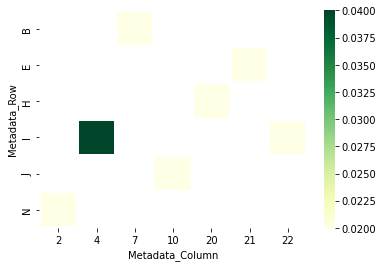

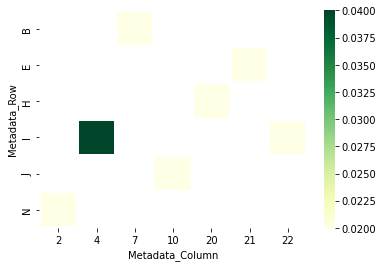

In [79]:
#@title Visualize missed wells

import seaborn as sns 
import pandas as pd 
from IPython import display

platelist = target['Target Plate'].unique().tolist()

visual = target
col =       visual['Target Well'].astype(str).str[1:3].to_list()
visual['Metadata_Column'] = [int(x) for x in col]
visual['Metadata_Row']    = visual['Target Well'].astype(str).str[0]


visual = visual.sort_values("Metadata_Column")

toplot = visual.pivot(columns="Metadata_Column", index="Metadata_Row", values="Volume [uL]") 

for plate in platelist:
  print(plate)
  hm = sns.heatmap(toplot, 
            #annot=norm_df,
            cmap="YlGn",
            cbar=True,
            lw=2)
  figure = hm.get_figure() 
  display.display(figure)

In [69]:
def createplate(size, direction):

    import string

    if size == 96:
        colr = 13
        rowr = 8
    
    if size == 384:
        colr = 25
        rowr = 16
    

    row = list(string.ascii_uppercase[:rowr])
    col = [(f'{i:02d}') for i in range(1, colr, 1)]
    wells = []
      
    if direction == "vert":
        for c in col:
            for r in row:
                wells.append(str(r+c))
        return(wells)
    
    else:
        for r in row:
            for c in col:
                wells.append(str(r+c))
        return(wells)

collcmpds = missed["Liquid Name"].unique().tolist()
wells = createplate(size = 96, direction= "vert")

In [73]:
#@title Assign stock solution to new sourceplate

welllist = []
dic = {}
    
for i, cmpd in enumerate(collcmpds):
        plate1 = {'Liquid Name': cmpd ,"Source Plate" : "sourceplate1", "Source Well" : wells[i] }
        welllist.append(plate1)
          
source = pd.DataFrame.from_dict(welllist)
sourceplates = source['Source Plate'].unique().tolist()
source

,Liquid Name,Source Plate,Source Well
0,[flup][10],sourceplate1,A01


In [77]:
#@title Next step is to create and format the idot protocol
def removeleadingzero(x):
    x = x[0] + x[1:3].lstrip("0")
    return x 
    
source['Source Well']          = source['Source Well'].apply(removeleadingzero)

sourcewell = source[["Liquid Name","Source Well"]]
sourcedictwell = dict(sourcewell.values)

sourceplate = source[["Liquid Name","Source Plate"]]
sourceplatedict = dict(sourceplate.values)

target["Source Well"]  = target["Liquid Name"].map(sourcedictwell)
target["Source Plate"] = target["Liquid Name"].map(sourceplatedict)

sourceplates = source['Source Plate'].unique().tolist()
targetplates = target['Target Plate'].unique().tolist()

sourceplates = sourceplates[::-1]

targetformat = target[["Target Plate","Target Well","Volume [uL]","Liquid Name"]]

collected_df = []
i = 1

for splate in sourceplates:
    for tplate in targetplates:
        df = target.loc[((target["Source Plate"] == splate) & (target["Target Plate"] == tplate ) )]
                      
        df = df[["Source Well","Target Well","Volume [uL]","Liquid Name"]]
        df = df.reindex(columns=[*df.columns.tolist(), "", "","",""], fill_value="")
          
        df = pd.concat([df.columns.to_frame().T, df], ignore_index=True)
        df.columns = range(len(df.columns)) 
        
        subheader = [[sourceplate_type, splate, "",max_volume, target_plate_type, tplate, "",waste],
        ["DispenseToWaste="+str(dispense_to_waste),"DispenseToWasteCycles="+str(dispense_to_waste_cycles),"DispenseToWasteVolume="+str(dispense_to_waste_volume),"UseDeionisation="+str(use_deionisation),"OptimizationLevel="+str(optimization_level),"WasteErrorHandlingLevel="+str(waste_error_handling_level),"SaveLiquids="+str(save_liquids),""]]
        subheader = pd.DataFrame(subheader)
        
        protocol = pd.concat([subheader, df],ignore_index=True)
        collected_df.append(protocol)

header = [[protocol_name, software, user_name, date, time,"","",""]]
header = pd.DataFrame(header)

dfs = pd.concat(collected_df)
fullprotocol = pd.concat([header, dfs],ignore_index=True)
fullprotocol

,0,1,2,3,4,5,6,7
0,myexp,1.7.2021.1019,Jonne,01/24/23,01:20:41,,,
1,S.100 Plate,sourceplate1,,0.00008,MWP 384,plate_1,,Waste Tube
2,DispenseToWaste=True,DispenseToWasteCycles=3,DispenseToWasteVolume=1e-07,UseDeionisation=True,OptimizationLevel=ReorderAndParallel,WasteErrorHandlingLevel=Ask,SaveLiquids=Ask,
3,Source Well,Target Well,Volume [uL],Liquid Name,,,,
4,A1,N2,0.02,[flup][10],,,,
5,A1,I4,0.04,[flup][10],,,,
6,A1,B7,0.02,[flup][10],,,,
7,A1,J10,0.02,[flup][10],,,,
8,A1,H20,0.02,[flup][10],,,,
9,A1,E21,0.02,[flup][10],,,,
